### Setup

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

!ln -s /content/gdrive/ /mydrive

Mounted at /content/gdrive


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4457856644452843999
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12652258214874684987
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [3]:
!pip -q install timm

     |████████████████████████████████| 431 kB 7.6 MB/s 


In [4]:
from __future__ import print_function

import glob
from itertools import chain
import time
import os
import random
import zipfile
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import timm

%config InlineBackend.figure_format = 'retina'

In [5]:
print(f"Torch: {torch.__version__}")

Torch: 1.10.0+cu111


### Dataset Setup

In [6]:
!unzip '/content/gdrive/MyDrive/Dataset/COVID-CTset/Train&Validation.zip' -d '/content/data'

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/normal2_patient329_SR_2_IM00024.tif  
  inflating: /content/data/normal2_patient329_SR_2_IM00025.tif  
  inflating: /content/data/normal2_patient329_SR_2_IM00026.tif  
  inflating: /content/data/normal2_patient329_SR_2_IM00028.tif  
  inflating: /content/data/normal2_patient329_SR_2_IM00029.tif  
  inflating: /content/data/normal2_patient329_SR_2_IM00030.tif  
  inflating: /content/data/normal2_patient329_SR_2_IM00031.tif  
  inflating: /content/data/normal2_patient329_SR_2_IM00032.tif  
  inflating: /content/data/normal2_patient329_SR_2_IM00033.tif  
  inflating: /content/data/normal2_patient329_SR_2_IM00034.tif  
  inflating: /content/data/normal2_patient329_SR_2_IM00035.tif  
  inflating: /content/data/normal2_patient329_SR_2_IM00036.tif  
  inflating: /content/data/normal2_patient329_SR_2_IM00037.tif  
  inflating: /content/data/normal2_patient329_SR_2_IM00038.tif  
  inflating: /content/data/normal2_pati

In [7]:
import pandas as pd
train1 = pd.read_csv('/content/gdrive/MyDrive/Dataset/COVID-CTset/CSV/train1.csv')
train2 = pd.read_csv('/content/gdrive/MyDrive/Dataset/COVID-CTset/CSV/train2.csv')
train3 = pd.read_csv('/content/gdrive/MyDrive/Dataset/COVID-CTset/CSV/train3.csv')
train4 = pd.read_csv('/content/gdrive/MyDrive/Dataset/COVID-CTset/CSV/train4.csv')
train5 = pd.read_csv('/content/gdrive/MyDrive/Dataset/COVID-CTset/CSV/train5.csv')

train_df = pd.concat([train1, train2, train3, train4, train5])

test1 = pd.read_csv('/content/gdrive/MyDrive/Dataset/COVID-CTset/CSV/test1.csv')
test2 = pd.read_csv('/content/gdrive/MyDrive/Dataset/COVID-CTset/CSV/test2.csv')
test3 = pd.read_csv('/content/gdrive/MyDrive/Dataset/COVID-CTset/CSV/test3.csv')
test4 = pd.read_csv('/content/gdrive/MyDrive/Dataset/COVID-CTset/CSV/test4.csv')
test5 = pd.read_csv('/content/gdrive/MyDrive/Dataset/COVID-CTset/CSV/test5.csv')

test_df = pd.concat([test1, test2, test3, test4, test5])

val1 = pd.read_csv('/content/gdrive/MyDrive/Dataset/COVID-CTset/CSV/validation1.csv')
val2 = pd.read_csv('/content/gdrive/MyDrive/Dataset/COVID-CTset/CSV/validation2.csv')
val3 = pd.read_csv('/content/gdrive/MyDrive/Dataset/COVID-CTset/CSV/validation3.csv')
val4 = pd.read_csv('/content/gdrive/MyDrive/Dataset/COVID-CTset/CSV/validation4.csv')
val5 = pd.read_csv('/content/gdrive/MyDrive/Dataset/COVID-CTset/CSV/validation5.csv')

val_df = pd.concat([val1, val2, val3, val4, val5])

all_df = pd.concat([train_df, test_df, val_df])
all_df = all_df.drop_duplicates(subset=['filename', 'class'], keep='first')
all_df

# The csv files provided shows the dataset is used in 5 folds. 
# Therefore, there will be duplicates.
# We remove the duplicates here.

,filename,class
0,137covid_patient1_SR_2_IM00010.tif,covid
1,137covid_patient1_SR_2_IM00011.tif,covid
2,137covid_patient1_SR_2_IM00012.tif,covid
3,137covid_patient1_SR_2_IM00013.tif,covid
4,137covid_patient1_SR_2_IM00014.tif,covid
...,...,...
6598,normal5_patient194_SR_2_IM00036.tif,normal
6599,normal5_patient194_SR_2_IM00037.tif,normal
6600,normal5_patient194_SR_2_IM00038.tif,normal
6601,normal5_patient194_SR_2_IM00039.tif,normal


In [8]:
import pandas as pd
# df["class"].explode().unique() 
covid_df = all_df.loc[all_df['class'] == 'covid']
normal_df = all_df.loc[all_df['class'] == 'normal']
covid_files = covid_df['filename'].tolist()  # 2282
normal_files = normal_df['filename'].tolist()  # 9776

In [9]:
!mkdir '/content/dataset'
!mkdir '/content/dataset/Covid'
!mkdir '/content/dataset/Normal'

In [10]:
import shutil
import os
    
source_dir = '/content/data'
covid_dir = '/content/dataset/Covid'
    
for file_name in covid_files:
    shutil.move(os.path.join(source_dir, file_name), covid_dir)

source_dir = '/content/data'
normal_dir = '/content/dataset/Normal'
    
for file_name in normal_files:
    shutil.move(os.path.join(source_dir, file_name), normal_dir)

In [11]:
!rm -r /content/data

### Load Data and Configure Training settings

In [12]:
# Training settings
batch_size = 32
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [14]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225] )
    ])

In [15]:
import torchvision
from torchvision.transforms import ToTensor

full_data = torchvision.datasets.ImageFolder('/content/dataset/', transform=TRANSFORM_IMG)
train_data, test_data, valid_data = torch.utils.data.random_split(full_data, [9646, 1206, 1206])

In [16]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader  = data.DataLoader(test_data, batch_size=batch_size, shuffle=True) 

In [17]:
print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))
print(len(test_data), len(test_loader))

9646 302
1206 38
1206 38


In [18]:
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k',
 'crossvit_9_240',
 'crossv

## ConvNeXt

In [19]:
device = 'cuda'

model = timm.create_model('convnext_small', pretrained=True, num_classes=2).to(device)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_1k_224_ema.pth


In [20]:
model

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine

### Training

In [21]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

n_epochs_stop = 3

min_val_loss = 10

In [22]:
epoch_l = []
loss_l = []
acc_l = []
v_loss_l = []
v_acc_l = []

In [23]:
since = time.time()
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
        
        epoch_l.append(epoch+1)
        loss_l.append(epoch_loss)
        acc_l.append(epoch_accuracy)
        v_loss_l.append(epoch_val_loss)
        v_acc_l.append(epoch_val_accuracy)
        
        print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n")
        
        if epoch_val_loss < min_val_loss:
            # Saving the model
            best_model = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            min_val_loss = epoch_val_loss
            early_stoped = False

        else:
            epochs_no_improve += 1
            # Check early stopping condition
            if epochs_no_improve == n_epochs_stop:
                print('Early stopping!' )
                model.load_state_dict(best_model)
                early_stoped = True
                break
    if early_stoped:
        break

elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

  0%|          | 0/302 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.1675 - acc: 0.9335 - val_loss : 0.0641 - val_acc: 0.9811



  0%|          | 0/302 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0353 - acc: 0.9884 - val_loss : 0.0288 - val_acc: 0.9918



  0%|          | 0/302 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0139 - acc: 0.9954 - val_loss : 0.0264 - val_acc: 0.9926



  0%|          | 0/302 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0057 - acc: 0.9982 - val_loss : 0.0218 - val_acc: 0.9918



  0%|          | 0/302 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0007 - acc: 0.9999 - val_loss : 0.0158 - val_acc: 0.9951



  0%|          | 0/302 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.0171 - val_acc: 0.9967



  0%|          | 0/302 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.0197 - val_acc: 0.9951



  0%|          | 0/302 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0198 - val_acc: 0.9967

Early stopping!
Training completed in 85m 39s


In [24]:
torch.save(model, './convnext_small_model_pretrained.pt')

### Testing

In [25]:
since = time.time()

y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

def flatten(new:list, target:list):
    for li in target:
        for value in list(li):
            new.append(value)

y_pred = []
y_true = []
flatten(y_pred, y_pred_list)
flatten(y_true, y_true_list)

elapsed_time = time.time() - since
print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

  0%|          | 0/38 [00:00<?, ?it/s]

Evaluation completed in 0m 26s


In [26]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
print("Overall accuracy:", accuracy_score(y_true, y_pred))
print("Overall F1:", f1_score(y_true, y_pred, average='weighted'))
print("Overall Loss:", log_loss(y_true, y_pred))

Overall accuracy: 0.9966832504145937
Overall F1: 0.9966782365273902
Overall Loss: 0.11455846133659577


In [27]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_true, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.99591837 0.99687825]
recall: [0.98785425 0.99895725]
fscore: [0.99186992 0.99791667]
support: [247 959]


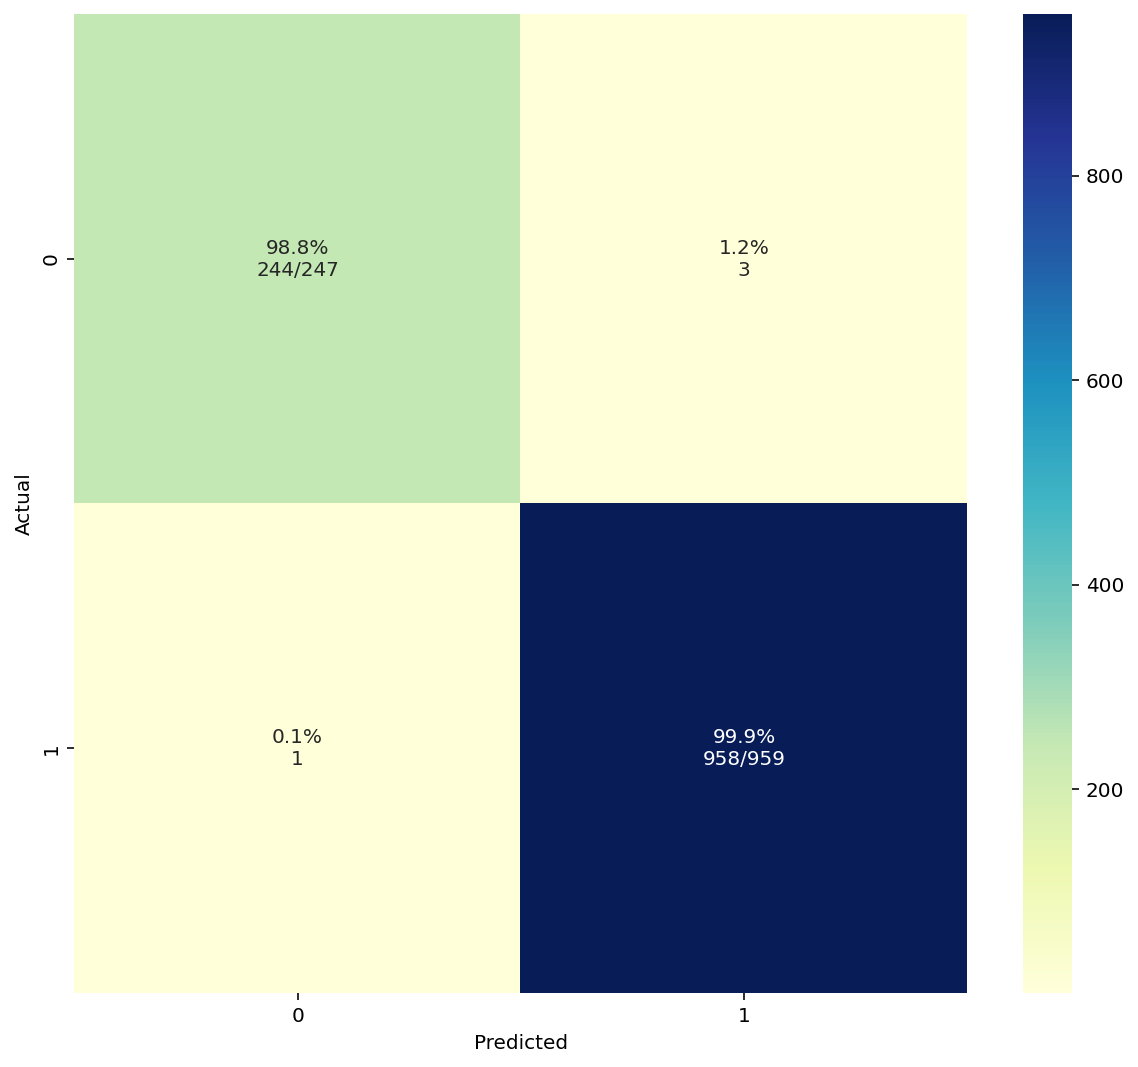

In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

def plot_cm(y_true, y_pred, figsize=(10,9)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

plot_cm(y_true, y_pred)

display()

In [29]:
loss_l_c = []
acc_l_c = []
v_loss_l_c = []
v_acc_l_c = []
for x in loss_l:
    x = x.cpu().detach().numpy()
    loss_l_c.append(x)
for x in acc_l:
    x = x.cpu().detach().numpy()
    acc_l_c.append(x)
for x in v_loss_l:
    x = x.cpu().detach().numpy()
    v_loss_l_c.append(x)
for x in v_acc_l:
    x = x.cpu().detach().numpy()
    v_acc_l_c.append(x)

In [30]:
import plotly.graph_objects as go

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=epoch_l, y=loss_l_c,
                    mode='lines+markers',
                    name='Train loss'))
fig.add_trace(go.Scatter(x=epoch_l, y=acc_l_c,
                    mode='lines+markers',
                    name='Train accuracy'))
fig.add_trace(go.Scatter(x=epoch_l, y=v_loss_l_c,
                    mode='lines+markers',
                    name='Validation loss'))
fig.add_trace(go.Scatter(x=epoch_l, y=v_acc_l_c,
                    mode='lines+markers',
                    name='Validation accuracy'))
fig.update_layout(
    title='convnext_small (pre-trained)',
    autosize=False,
    width=1000,
    height=600,
)

fig.show()

### Inference

In [31]:
def predict_image(image):
    image_tensor = TRANSFORM_IMG(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [32]:
classes = ['COVID', 'Normal']
def get_random_images(num):
    # classes = test_data.classes
    indices = list(range(len(test_data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(test_data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

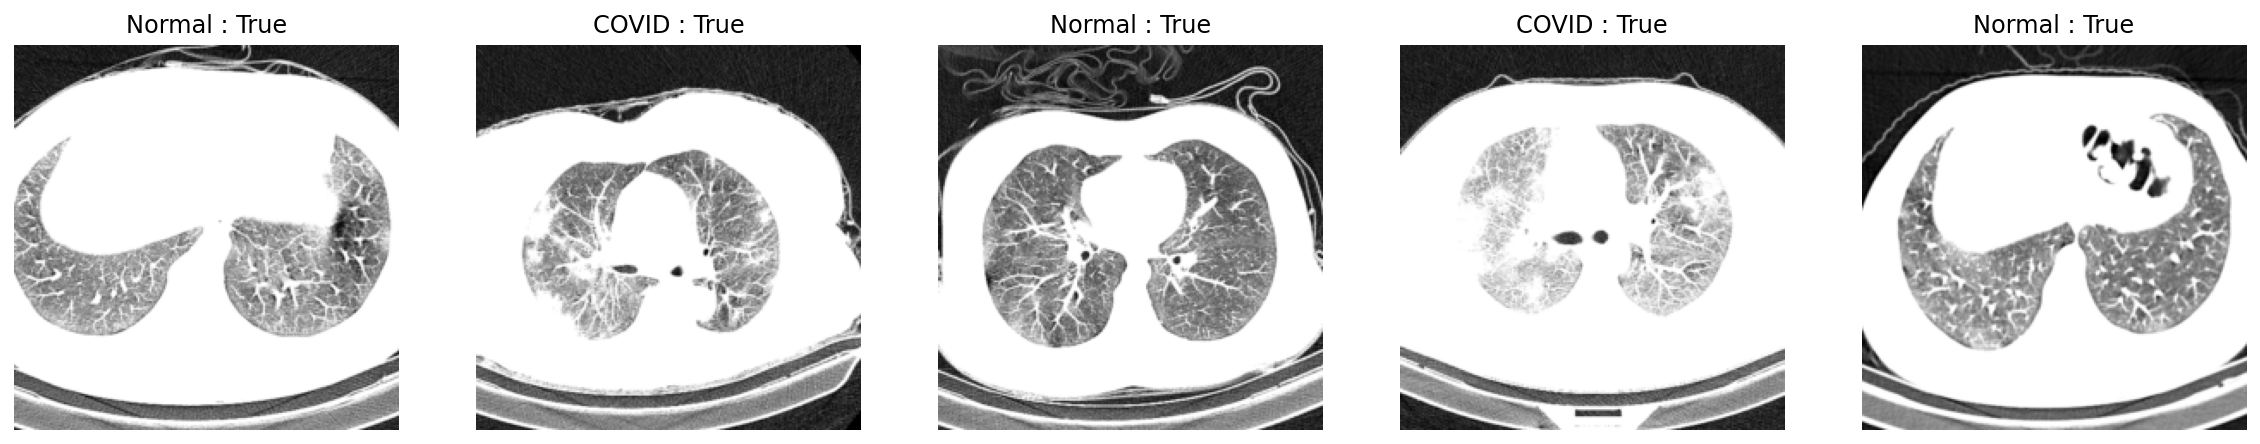

In [33]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(20,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + " : " + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()